# Test Global Mangrove Watch

In [ ]:
import os
from shapely import wkb
from shapely.geometry import Polygon, box
import geopandas as gpd
import openeo
import openeo.processes
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [9]:
gdf = gpd.read_file("/home/nus/workspace/datasets/gmw_v3_2020_vec/gmw_v3_2020_vec.shp")
print(gdf.head())

   PXLVAL                                           geometry
0       1  POLYGON ((172.05689 6.01844, 172.05711 6.01844...
1       1  POLYGON ((172.05689 6.01711, 172.05711 6.01711...
2       1  POLYGON ((172.05511 6.01622, 172.05644 6.01622...
3       1  POLYGON ((172.06178 6.01333, 172.062 6.01333, ...
4       1  POLYGON ((172.06289 6.01333, 172.06311 6.01333...


In [10]:
print(gdf.head())         # See first few rows
print(gdf.columns)        # List all attribute columns
print(gdf.crs)            # Coordinate Reference System
print(gdf.shape)          # Number of features (rows) and columns

   PXLVAL                                           geometry
0       1  POLYGON ((172.05689 6.01844, 172.05711 6.01844...
1       1  POLYGON ((172.05689 6.01711, 172.05711 6.01711...
2       1  POLYGON ((172.05511 6.01622, 172.05644 6.01622...
3       1  POLYGON ((172.06178 6.01333, 172.062 6.01333, ...
4       1  POLYGON ((172.06289 6.01333, 172.06311 6.01333...
Index(['PXLVAL', 'geometry'], dtype='object')
EPSG:4326
(1076117, 2)


In [ ]:
gdf['area_m2'] = gdf.geometry.to_crs(epsg=3035).area  #TODO: Verify how true this is
gdf['area_m2']

0          6.045941e+02
1          4.836674e+03
2          8.464543e+03
3          6.045997e+02
4          6.045997e+02
               ...     
1076112    3.528336e+03
1076113    2.083562e+06
1076114    1.469984e+04
1076115    1.058372e+04
1076116    2.398973e+05
Name: area_m2, Length: 1076117, dtype: float64

POLYGON ((-39.030666666667635 -14.879777777776898, -39.030222222223195 -14.879777777776898, -39.030222222223195 -14.87999999999912, -39.03000000000097 -14.87999999999912, -39.03000000000097 -14.879777777776898, -39.02977777777875 -14.879777777776898, -39.02977777777875 -14.87999999999912, -39.02933333333431 -14.87999999999912, -39.02933333333431 -14.880222222221342, -39.02888888888986 -14.880222222221342, -39.02888888888986 -14.880444444443564, -39.02866666666764 -14.880444444443564, -39.02866666666764 -14.880666666665785, -39.02777777777875 -14.880666666665785, -39.02777777777875 -14.880444444443564, -39.027555555556525 -14.880444444443564, -39.027555555556525 -14.880666666665785, -39.027333333334305 -14.880666666665785, -39.027333333334305 -14.880444444443564, -39.027111111112085 -14.880444444443564, -39.027111111112085 -14.880666666665785, -39.026888888889864 -14.880666666665785, -39.026888888889864 -14.88111111111023, -39.02644444444542 -14.88111111111023, -39.02644444444542 -14.88

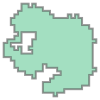

In [77]:
i = -1
print(gdf.iloc[i].geometry)
gdf.iloc[i].geometry

In [ ]:
wkt_string = f"POLYGON (({', '.join(f'{x} {y}' for x, y in gdf.iloc[i].geometry.exterior.coords)}))"

# Convert from WKT to shapely geometry
polygon = wkt.loads(wkt_string)

# Create a GeoDataFrame, add any properties you want
gdf = gpd.GeoDataFrame([{"geometry": polygon, "PXLVAL": 1, "area_m2": polygon.area}], crs="EPSG:4326")

# Export to GeoJSON
gdf.to_file("polygon_feature_test.geojson", driver="GeoJSON")

### Using openeo

See https://documentation.dataspace.copernicus.eu/APIs/openEO/openeo-community-examples/python/OilSpill/OilSpillMapping.html

In [31]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [72]:
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2022-05-01", "2022-05-30"),
    spatial_extent={
        "west": gdf.iloc[i].geometry.bounds[0],
        "south": gdf.iloc[i].geometry.bounds[1],
        "east": gdf.iloc[i].geometry.bounds[2],
        "north": gdf.iloc[i].geometry.bounds[3],
        "crs": "EPSG:4326",
    },
    bands=["B04", "B03", "B02", "SCL"],
    max_cloud_cover=50,
)

s2_cube.download("load-s2.nc")

ds = xr.load_dataset("load-s2.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")
print(data.shape)

(3, 3, 65, 63)


(65, 63, 3)


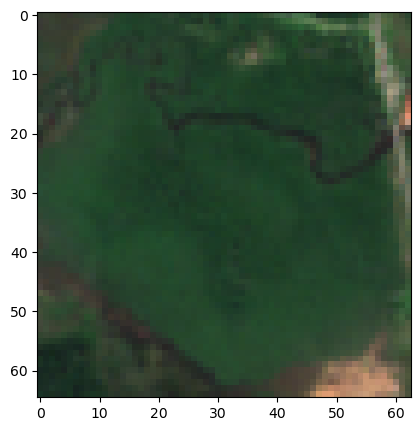

In [73]:
t0 = data.t.values[0]

# Select the bands at time t0, order: R, G, B
r = data.sel(bands='B04', t=t0)
g = data.sel(bands='B03', t=t0)
b = data.sel(bands='B02', t=t0)

rgb = np.stack([r, g, b], axis=-1)
print(rgb.shape)

plt.figure(figsize=(5, 5))
plt.imshow(rgb / 2000)  # scale values to [0, 1] for display

In [74]:
s1_cube = connection.load_collection(
    "SENTINEL1_GRD",    # Sentinel-1 product name may differ by platform!
    temporal_extent=("2022-05-01", "2022-05-30"),
    spatial_extent={
        "west": gdf.iloc[i].geometry.bounds[0],
        "south": gdf.iloc[i].geometry.bounds[1],
        "east": gdf.iloc[i].geometry.bounds[2],
        "north": gdf.iloc[i].geometry.bounds[3],
        "crs": "EPSG:4326",
    },
    bands=["VV", "VH"],   # Choose polarizations relevant for your use case
    # Sentinel-1 does not have cloud cover filtering
)

s1_cube.download("load-s1.nc")

ds = xr.load_dataset("load-s1.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["VV", "VH"]].to_array(dim="bands")
print(data.shape)

(2, 3, 65, 63)


(65, 63)


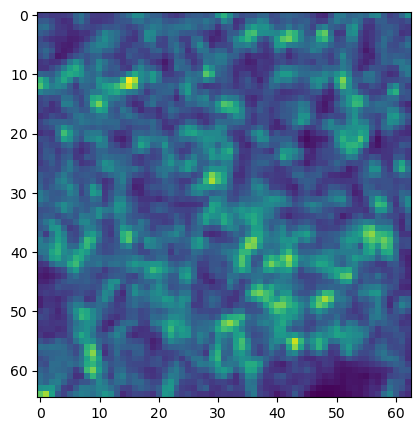

In [76]:
t0 = data.t.values[0]

# Select the bands at time t0, order: R, G, B
vv = data.sel(bands='VV', t=t0)
vh = data.sel(bands='VH', t=t0)

amplitude = vv+vh
print(amplitude.shape)

plt.figure(figsize=(5, 5))
plt.imshow(amplitude)